<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap09/9_4_Bayesian_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 9.4: Bayesian approach**

This notebook investigates the Bayesian approach to model fitting and reproduces figure 9.11 from the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
# Define seed to get same results each time
np.random.seed(1)

In [2]:
# The true function that we are trying to estimate, defined on [0,1]
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

In [3]:
# Generate some data points with or without noise
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # y value from running through function and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y

In [4]:
# Draw the fitted function, together with uncertainty used to generate points
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, $x$')
    ax.set_ylabel('Output, $y$')
    plt.show()

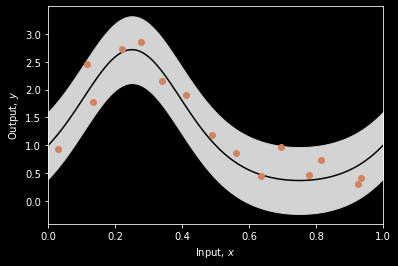

In [5]:
# Generate true function
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

# Generate some data points
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

# Plot the function, data and uncertainty
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [6]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y

Now let's compute a probability distribution over the model parameters using Bayes's rule:

\begin{equation}
 Pr(\boldsymbol\phi|\{\mathbf{x}_{i},\mathbf{y}_{i}\}) = \frac{\prod_{i=1}^{I} Pr(\mathbf{y}_{i}|\mathbf{x}_{i},\boldsymbol\phi) Pr(\boldsymbol\phi)}{\int \prod_{i=1}^{I} Pr(\mathbf{y}_{i}|\mathbf{x}_{i},\boldsymbol\phi) Pr(\boldsymbol\phi)d\boldsymbol\phi } ,
\end{equation}

We'll define the prior $Pr(\boldsymbol\phi)$ as:

\begin{equation}
Pr(\boldsymbol\phi) = \text{Norm}_{\boldsymbol\phi}\bigl[\mathbf{0},\sigma^2_p\mathbf{I}\bigr]
\end{equation}

where $\phi=[\omega_1,\omega_2\ldots \omega_n, \beta]^T$ and $\sigma^2_{p}$  is the prior variance.

The likelihood term $\prod_{i=1}^{I} Pr(\mathbf{y}_{i}|\mathbf{x}_{i},\boldsymbol\phi)$ is given by:

\begin{align}
\prod_{i=1}^{I} Pr(\mathbf{y}_{i}|\mathbf{x}_{i},\boldsymbol\phi) &=& \prod_{i=1}^{I} \text{Norm}_{y_i}\bigl[\text{f}[\mathbf{x}_{i},\boldsymbol\phi],\sigma_d^2\bigr]\\
&=& \prod_{i=1}^{I} \text{Norm}_{y_i}\bigl[\boldsymbol\omega\mathbf{h}_i+\beta,\sigma_d^2\bigr]\\
&=& \text{Norm}_{\mathbf{y}}\bigl[\mathbf{H}^T\boldsymbol\phi,\sigma^2\mathbf{I}\bigr].
\end{align}

where $\sigma^2$ is the measurement noise and $\mathbf{h}_{i}$ is the column vector of hidden variables for the $i^{th}$ input.  Here the vector $\mathbf{y}$ and matrix $\mathbf{H}$ are defined as:

\begin{equation}
\mathbf{y} = \begin{bmatrix}y_1\\y_2\\\vdots\\y_{I}\end{bmatrix}\quad\text{and}\quad \mathbf{H} = \begin{bmatrix}\mathbf{h}_{1}&\mathbf{h}_{2}&\cdots&\mathbf{h}_{I}\\1&1&\cdots &1\end{bmatrix}.
\end{equation}


To make progress we use the change of variable relation (Appendix C.3.4 of the book) to rewrite the likelihood term as a normal distribution in the parameters $\boldsymbol\phi$:

\begin{align}
\prod_{i=1}^{I} Pr(\mathbf{y}_{i}|\mathbf{x}_{i},\boldsymbol\phi+\beta)
&=& \text{Norm}_{\mathbf{y}}\bigl[\mathbf{H}^T\boldsymbol\phi,\sigma^2\bigr]\\
&\propto& \text{Norm}_{\boldsymbol\phi}\bigl[(\mathbf{H}\mathbf{H}^T)^{-1}\mathbf{H}\mathbf{y},\sigma^2(\mathbf{H}\mathbf{H}^t)^{-1}\bigr]
\end{align}


Finally, we can combine the likelihood and prior terms using the product of two normal distributions relation (Appendix C.3.3).

\begin{align}
 Pr(\boldsymbol\phi|\{\mathbf{x}_{i},\mathbf{y}_{i}\}) &\propto& \prod_{i=1}^{I} Pr(\mathbf{y}_{i}|\mathbf{x}_{i},\boldsymbol\phi) Pr(\boldsymbol\phi)\\
 &\propto&\text{Norm}_{\boldsymbol\phi}\bigl[(\mathbf{H}\mathbf{H}^T)^{-1}\mathbf{H}\mathbf{y},\sigma^2(\mathbf{H}\mathbf{H}^T)^{-1}\bigr] \text{Norm}_{\boldsymbol\phi}\bigl[\mathbf{0},\sigma^2_p\mathbf{I}\bigr]\\
 &\propto&\text{Norm}_{\boldsymbol\phi}\biggl[\frac{1}{\sigma^2}\left(\frac{1}{\sigma^2}\mathbf{H}\mathbf{H}^T+\frac{1}{\sigma_p^2}\mathbf{I}\right)^{-1}\mathbf{H}\mathbf{y},\left(\frac{1}{\sigma^2}\mathbf{H}\mathbf{H}^T+\frac{1}{\sigma_p^2}\mathbf{I}\right)^{-1}\biggr].
\end{align}

In fact, since this is already a normal distribution, the constant of proportionality must be one and we can write

\begin{align}
 Pr(\boldsymbol\phi|\{\mathbf{x}_{i},\mathbf{y}_{i}\}) &=& \text{Norm}_{\boldsymbol\phi}\biggl[\frac{1}{\sigma^2}\left(\frac{1}{\sigma^2}\mathbf{H}\mathbf{H}^T+\frac{1}{\sigma_p^2}\mathbf{I}\right)^{-1}\mathbf{H}\mathbf{y},\left(\frac{1}{\sigma^2}\mathbf{H}\mathbf{H}^T+\frac{1}{\sigma_p^2}\mathbf{I}\right)^{-1}\biggr].
\end{align}

TODO -- On a piece of paper, use the relations in Appendix C.3.3 and C.3.4 to fill in the missing steps and establish that this is the correct formula for the posterior.

In [9]:
def compute_H(x_data, n_hidden):
  psi1 = np.ones((n_hidden+1,1));
  psi0 = np.linspace(0.0, 1.0, num=n_hidden, endpoint=False) * -1

  n_data = x_data.size
  # First compute the hidden variables
  H = np.ones((n_hidden+1, n_data))
  for i in range(n_hidden):
    for j in range(n_data):
      # Compute preactivation
      H[i,j] = psi1[i] * x_data[j]+psi0[i]
      # Apply ReLU to get activation
      if H[i,j] < 0:
        H[i,j] = 0;

  return H

def compute_param_mean_covar(x_data, y_data, n_hidden, sigma_sq, sigma_p_sq):
  # Retrieve the matrix containing the hidden variables
  H = compute_H(x_data, n_hidden) ;

  # TODO -- Compute the covariance matrix (you will need np.transpose(), np.matmul(), np.linalg.inv())
  # Replace this line
  phi_covar =  np.linalg.inv((1/sigma_sq) * np.matmul(H, H.transpose()) + (1/sigma_p_sq) * np.identity(n_hidden+1))


  # TODO -- Compute the mean matrix
  # Replace this line
  phi_mean = (1/sigma_sq) * np.matmul(np.linalg.inv((1/sigma_sq) * np.matmul(H, H.transpose()) + (1/sigma_p_sq) * np.identity(n_hidden+1)), np.matmul(H, y_data))


  return phi_mean, phi_covar

Now we can draw samples from this distribution

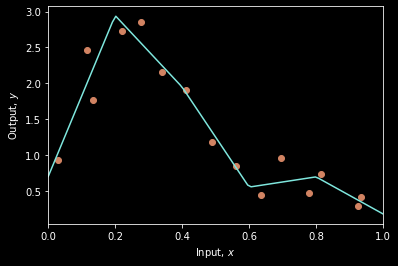

In [32]:
# Define parameters
n_hidden = 5
sigma_sq = sigma_func * sigma_func
# Arbitrary large value reflecting the fact we are uncertain about the
# parameters before we see any data
sigma_p_sq = 1000

# Compute the mean and covariance matrix
phi_mean, phi_covar = compute_param_mean_covar(x_data, y_data, n_hidden, sigma_sq, sigma_p_sq)

# Let's draw the mean model
x_model = x_func
y_model_mean = network(x_model, phi_mean[-1], phi_mean[0:n_hidden])
plot_function(x_func, y_func, x_data, y_data, x_model, y_model_mean)

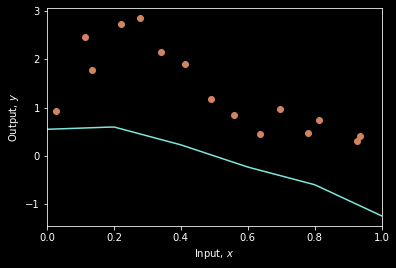

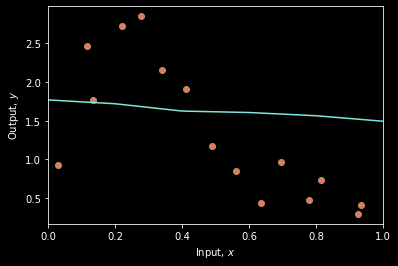

In [33]:
# TODO Draw two samples from the normal distribution over the parameters
# Replace these lines
phi_sample1 = np.random.normal(0, 1, n_hidden+1)
phi_sample2 = np.random.normal(0, 1, n_hidden+1)


# Run the network for these two sample sets of parameters
y_model_sample1 = network(x_model, phi_sample1[-1], phi_sample1[0:n_hidden])
y_model_sample2 = network(x_model, phi_sample2[-1], phi_sample2[0:n_hidden])

# Draw the two models
plot_function(x_func, y_func, x_data, y_data, x_model, y_model_sample1)
plot_function(x_func, y_func, x_data, y_data, x_model, y_model_sample2)

Now we need to perform inference for a new data points $\mathbf{x}^*$ with corresponding hidden values $\mathbf{h}^*$.  Instead of having a single estimate of the parameters, we have a distribution over the possible parameters.  So we marginalize (integrate) over this distribution to account for all possible values:

\begin{align}
Pr(y^*|\mathbf{x}^*)  &= \int Pr(y^{*}|\mathbf{x}^*,\boldsymbol\phi)Pr(\boldsymbol\phi|\{\mathbf{x}_{i},\mathbf{y}_{i}\}) d\boldsymbol\phi\\
&= \int \text{Norm}_{y^*}\bigl[[\mathbf{h}^{*T},1]\boldsymbol\phi,\sigma^2\bigr]\cdot\text{Norm}_{\boldsymbol\phi}\biggl[\frac{1}{\sigma^2}\left(\frac{1}{\sigma^2}\mathbf{H}\mathbf{H}^T+\frac{1}{\sigma_p^2}\mathbf{I}\right)^{-1}\mathbf{H}\mathbf{y},\left(\frac{1}{\sigma^2}\mathbf{H}\mathbf{H}^T+\frac{1}{\sigma_p^2}\mathbf{I}\right)^{-1}\biggr]d\boldsymbol\phi\\
&= \text{Norm}_{y^*}\biggl[\frac{1}{\sigma^2} [\mathbf{h}^{*T},1]\left(\frac{1}{\sigma^2}\mathbf{H}\mathbf{H}^T+\frac{1}{\sigma_p^2}\mathbf{I}\right)^{-1}\mathbf{H}\mathbf{y},  [\mathbf{h}^{*T},1]\left(\frac{1}{\sigma^2}\mathbf{H}\mathbf{H}^T+\frac{1}{\sigma_p^2}\mathbf{I}\right)^{-1}
[\mathbf{h}^*;1]\biggr],
\end{align}

where the notation $[\mathbf{h}^{*T},1]$ is a row vector containing $\mathbf{h}^{T}$ with a one appended to the end and $[\mathbf{h};1 ]$ is a column vector containing $\mathbf{h}$ with a one appended to the end.


To compute this, we reformulated the integrand using the relations from appendices C.3.3 and C.3.4 as the product of a normal distribution in $\boldsymbol\phi$ and a constant with respect
to $\boldsymbol\phi$. The integral of the normal distribution must be one, and so the final result is just the constant. This constant is itself a normal distribution in $y^*$. <br>

If you feel so inclined you can work through the math of this yourself.



In [34]:
# Predict mean and variance of y_star from x_star
def inference(x_star, x_data, y_data, sigma_sq, sigma_p_sq, n_hidden):

  # Compute hidden variables
  h_star = compute_H(x_star, n_hidden);
  H = compute_H(x_data, n_hidden);

  # TODO: Compute mean and variance of y*
  # Replace these lines:
  y_star_mean = (1/sigma_sq) * np.matmul(np.matmul(h_star.transpose(), np.linalg.inv((1/sigma_sq) * np.matmul(H, H.transpose()) + (1/sigma_p_sq) * np.identity(n_hidden+1))), np.matmul(H, y_data))
  y_star_var =  np.matmul(np.matmul(h_star.transpose(), np.linalg.inv((1/sigma_sq) * np.matmul(H, H.transpose()) + (1/sigma_p_sq) * np.identity(n_hidden+1))), h_star)

  return y_star_mean, y_star_var

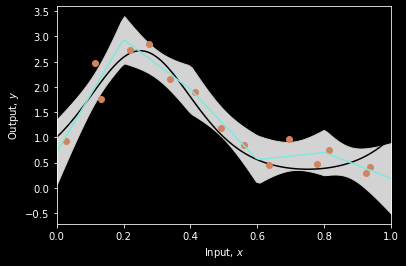

In [35]:
x_model = x_func
y_model = np.zeros_like(x_model)
y_model_std = np.zeros_like(x_model)
for c_model in range(len(x_model)):
  y_star_mean, y_star_var = inference(x_model[c_model]*np.ones((1,1)), x_data, y_data, sigma_sq, sigma_p_sq, n_hidden)
  y_model[c_model] = y_star_mean
  y_model_std[c_model] = np.sqrt(y_star_var)

# Draw the model
plot_function(x_func, y_func, x_data, y_data, x_model, y_model, sigma_model=y_model_std)


TODO:

1.  Experiment running this again with different numbers of hidden units.  Make a prediction for what will happen when you increase / decrease them.
2.  Experiment with what happens if you make the prior variance $\sigma^2_p$ to a smaller value like 1.  How do you explain the results?

1. As the number of hidden units increase, the bias is reduced and the function is better fitted.
2. As the variance is lowered, the model doesn't fit very well the true function, this is driven by the reduction in the flexibility of the model.